## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install and use [OpenSlide](https://openslide.org/), the only non-Python dependency. Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, though, you'll need to install and run OpenSlide locally.

### Training data

This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains a few slides and tumor masks prepared in advance with ASAP. This amount of data (or less!) should be sufficient for your project. The goal is to build a thoughtful end-to-end prototype, not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442) discussed in class. If you would like more data than has been provided, you will need to use ASAP to convert it into an appropriate format. 


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 6 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (57.7 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
! pip install wget

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget

In [0]:
! ls -l --block-size=M

total 1M
drwxr-xr-x 1 root root 1M Apr  4 20:20 sample_data
-rw-r--r-- 1 root root 1M Apr 19 00:05 tumor_001.tif


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import cv2

In [19]:
!ls -l --block-size=M '/gdrive/My Drive/Colab Notebooks/slides'

total 32938M
-r-------- 1 root root   94M Oct 11  2018  tumor_001_mask.tif
-r-------- 1 root root 3114M Oct 11  2018  tumor_001.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_001.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_002_mask.tif
-r-------- 1 root root 1603M Oct 11  2018  tumor_002.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_002.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_005_mask.tif
-r-------- 1 root root 1400M Oct 11  2018  tumor_005.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_005.xml
-r-------- 1 root root   92M Oct 11  2018  tumor_012_mask.tif
-r-------- 1 root root 1552M Oct 11  2018  tumor_012.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_012.xml
-r-------- 1 root root   95M Oct 11  2018  tumor_016_mask.tif
-r-------- 1 root root 1454M Oct 11  2018  tumor_016.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_016.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_019_mask.tif
-r-------- 1 root root 1466M Oct 11  2018  tu

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [69]:
#get file in folder
files=os.listdir('/gdrive/My Drive/Colab Notebooks/slides')
files[:2]

['tumor_091_mask.tif', 'tumor_091.tif']

In [68]:
#get file name for slide & mask
slide_paths,tumor_mask_paths=[],[]
for item in files:
  if item[-4:] == '.tif':
    if item[-8:-4] == 'mask':
      tumor_mask_paths.append(item)
    else:
      slide_paths.append(item)
print('In total: %d slides.' % len(tumor_mask_paths))
slide_index = [item[6:9] for item in slide_paths]
print('Index of slides:',slide_index)

In total: 21 slides.
('Index of slides:', ['091', '001', '002', '005', '012', '016', '019', '023', '031', '035', '038', '057', '059', '064', '075', '078', '081', '084', '094', '096', '110', '101'])


In [71]:
#get level info about all slides
for i,item in enumerate(slide_paths):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+item
  slide=open_slide(real_path)
  print ("Slide no. %s with %d levels, width: %d, height: %d" % (slide_index[i],
                                                                      len(slide.level_dimensions),
                                                                      slide.level_dimensions[0][0], 
                                                                      slide.level_dimensions[0][1]))

Slide no. 091 with 8 levels, width: 61440, height: 53760
Slide no. 001 with 10 levels, width: 97792, height: 221184
Slide no. 002 with 10 levels, width: 97792, height: 219648
Slide no. 005 with 10 levels, width: 97792, height: 219648
Slide no. 012 with 10 levels, width: 97792, height: 215552
Slide no. 016 with 10 levels, width: 97792, height: 221184
Slide no. 019 with 10 levels, width: 97792, height: 219648
Slide no. 023 with 10 levels, width: 97792, height: 221184
Slide no. 031 with 10 levels, width: 97792, height: 221184
Slide no. 035 with 10 levels, width: 97792, height: 221184
Slide no. 038 with 10 levels, width: 97792, height: 221184
Slide no. 057 with 10 levels, width: 97792, height: 220672
Slide no. 059 with 10 levels, width: 97280, height: 221184
Slide no. 064 with 10 levels, width: 97792, height: 220672
Slide no. 075 with 9 levels, width: 90112, height: 78848
Slide no. 078 with 9 levels, width: 94208, height: 111104
Slide no. 081 with 9 levels, width: 90112, height: 100352
Sli

In [0]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

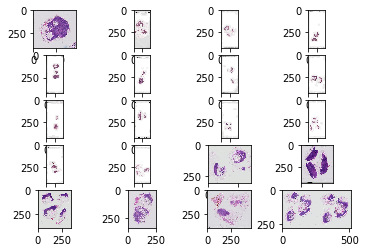

In [89]:
#show imgs at highest level to see general shape
for i in range(20):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[i]
  slide=open_slide(real_path)
  plt.subplot(5,4,i+1)
  level = len(slide.level_dimensions)-1
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  plt.imshow(slide_image)
plt.show()

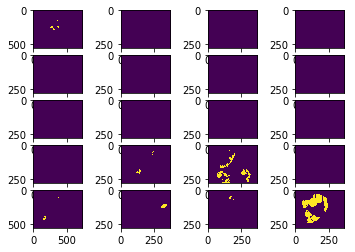

In [79]:
#show masks at highest level to see general shape
for i in range(20):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+tumor_mask_paths[i]
  mask=open_slide(real_path)
  plt.subplot(5,4,i+1)
  level = len(mask.level_dimensions)-1
  mask_image = read_slide(mask, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  mask_image = mask_image[:,:,1]
  plt.imshow(mask_image)
plt.show()

(2240, 2944, 3)


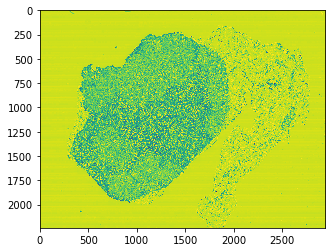

In [88]:
#experiment code block for displaying some img quickly
real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[20]
mask=open_slide(real_path)
level = 5#len(mask.level_dimensions)-1
mask_image = read_slide(mask, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
print(mask_image.shape)
mask_image = mask_image[:,:,2]
plt.imshow(mask_image)
plt.show()

In [0]:
#crop image from 

below are all start codes basically unchanged

In [0]:
slide_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[0]
tumor_mask_path = '/gdrive/My Drive/Colab Notebooks/slides/'+tumor_mask_paths[0]

In [102]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)-1):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /gdrive/My Drive/Colab Notebooks/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /gdrive/My Drive/Colab Notebooks/slides/tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

level: 1, width: 30720, height: 26880


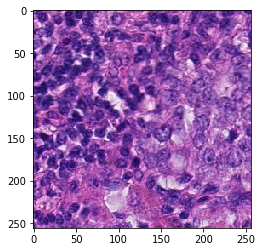

In [133]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.
level= 1
width=slide.level_dimensions[level][0]
height=slide.level_dimensions[level][1]
print('level: %d, width: %d, height: %d' % (level,width,height))
slide_image = read_slide(slide, 
                         x=32000, 
                         y=32000, 
                         level=level, 
                         width=256, 
                         height=256)

#plt.figure(figsize=(10,10))#, dpi=100)
plt.imshow(slide_image)

(256, 256, 3)


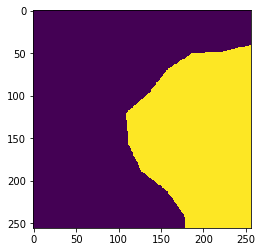

In [153]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=32000, 
                        y=32000, 
                        level=level, 
                        width=256, 
                        height=256)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
print(mask_image.shape)
mask_image = mask_image[:,:,2]

#plt.figure(figsize=(10,10))#, dpi=100)
plt.imshow(mask_image)

In [150]:
#get google drive folder list
folder_list = drive.ListFile({'q': "trashed=false"}).GetList()
for folder in folder_list:
  print 'folder title: %s, id: %s' % (folder['title'], folder['id'])

folder title: startercode.ipynb, id: 19EtJNMyYX66aNB0G-RokSvPyboRwQr1x
folder title: /gdrive/My Drive/Colab Notebooks/tmp/neg_label/try.png, id: 1QAbElUqk9p7yS9BnrngzV8tdjAtu4Nys
folder title: neg_label, id: 13oH2FzGZIplfhoKNTFbsFMbeSbRwjuYn
folder title: neg, id: 1U0yheoWuCrExw-DlmLCYNwJW6eSXMAlv
folder title: pos_label, id: 1DtTk8QvDZtYraUH1ML-4Py8_VacfRMxc
folder title: pos, id: 1ld8Tj44MH4UPPHRuoQ8wZqd2vMFXTAT_
folder title: tmp, id: 1iu1gJlTt1JYz3BOok18YbHHqEVUWz3hs
folder title: foo.txt, id: 1n5sagKMYeuk7wXuomaQP9rL6ZUscHhLJ
folder title: HW5_part2.ipynb, id: 1Y--CHfwQf2T8FLZYPsRGY-9AmTDMnrvX
folder title: HW5_part1.ipynb, id: 1U4-6tXU1l76dGT-pxF0UB5YsfobEPdVV
folder title: HW5_part3.ipynb, id: 1ep9MIjGoZhjbjV65BnfSFwmfYEcaBpjl
folder title: hw4_part1.ipynb, id: 1R6xQHlwF-lLy50_di9G2JkXNtp-_AJfF
folder title: HW4_part2.ipynb, id: 16rhwiq8A5hMuBQnbxqm1OGH0SftEX-ct
folder title: HW4_part1_ref.ipynb, id: 1If_kYkA3cvg3Nix7FJhWF5mYvqF-VXQI
folder title: ali.ipynb, id: 1kLyU2BmNTZbPpM-

In [0]:
#https://stackoverflow.com/questions/26783420/python-how-to-upload-files-to-a-specific-folder-in-google-drive-using-folderid
def upload_to_folder(folder_id, file_name_local, file_name_in_folder):
    file_metadata = {'title': file_name_in_folder, "parents": [{"id": folder_id, "kind": "drive#childList"}]}
    folder = drive.CreateFile(file_metadata)
    folder.SetContentFile(file_name_local) #The contents of the file
    folder.Upload()

In [156]:
folder_id = '13oH2FzGZIplfhoKNTFbsFMbeSbRwjuYn'
#save file to local disk
file_name_local = 'tmp.png'
cv2.imwrite(file_name_local,mask_image)
file_name_in_folder = 'tmp.png'
upload_to_folder(folder_id, file_name_local, file_name_in_folder)

KeyboardInterrupt: ignored

In [0]:
cv2.imwrite('tmp.png',mask_image)
uploaded = drive.CreateFile({'title': '/gdrive/My Drive/Colab Notebooks/tmp/neg_label/try.png'})
uploaded.SetContentFile('tmp.png')
uploaded.Upload()

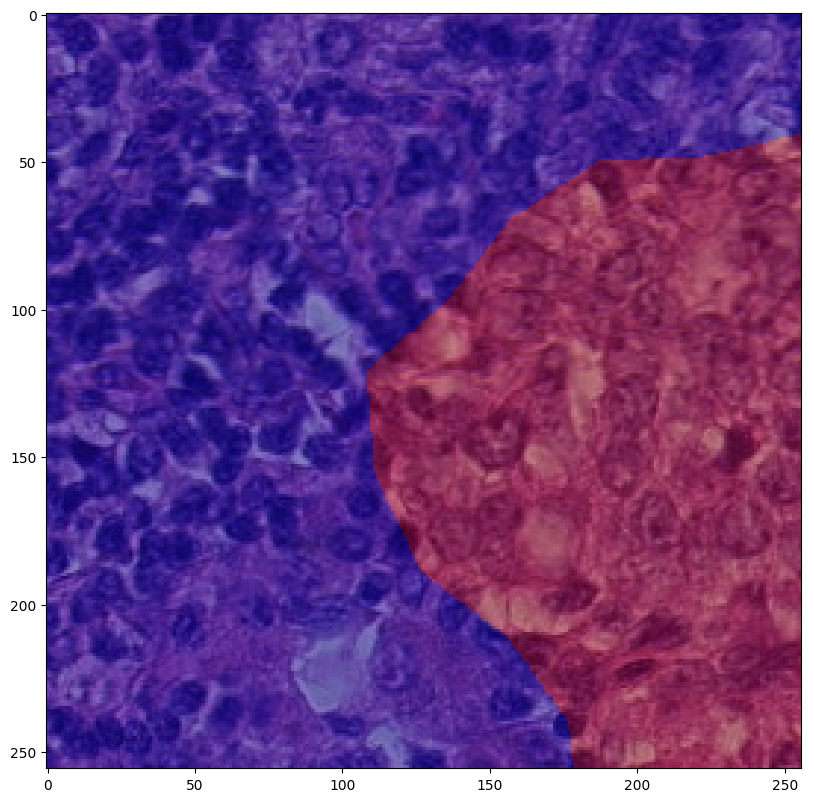

In [136]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

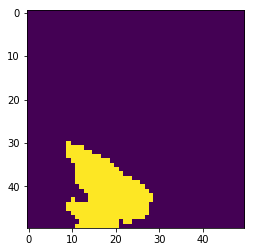

In [137]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

64417 tissue_pixels pixels (98.3 percent of the image)


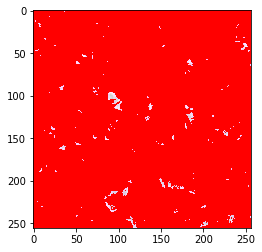

In [138]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [141]:
#cut slide from areas where intensity level qualifies(use function above to do so), 
#save positive patch & negative patch respectively to:
#pos patch: /Colab Notebooks/tmp/pos/
#pos label: /Colab Notebooks/tmp/pos_label/
#neg patch: /Colab Notebooks/tmp/neg/
#pos label: /Colab Notebooks/tmp/neg_label/
#need to create corresponding folder in google drive
patch_size=[slide.level_dimensions[1][0]//256,slide.level_dimensions[1][1]//256]
patch_size

[120, 105]

In [0]:
folder_id_neg_label = '13oH2FzGZIplfhoKNTFbsFMbeSbRwjuYn'

folder_id_neg = '1U0yheoWuCrExw-DlmLCYNwJW6eSXMAlv'

folder_id_pos_label = '1DtTk8QvDZtYraUH1ML-4Py8_VacfRMxc'

folder_id_pos = '1ld8Tj44MH4UPPHRuoQ8wZqd2vMFXTAT_'

In [0]:
#set threshold to be 0.05 for judging if the patch is pos or neg.
#i. e. if sum of mask is smaller than pos_label_intensity, then less than 5% of the label has tumor, label it as negative sample
label_threshold = 0.05
pos_label_intensity = (1 - threshold) * np.sum(255*np.ones([256,256]))
for col in range(patch_size[0]):
  for row in range(patch_size[1]):
    #get patch
    patch = read_slide(slide, 
                       x=col*2*256, 
                       y=row*2*256, 
                       level=1, 
                       width=256, 
                       height=256)    
    #calculate intensity
    tissue_pixels = find_tissue_pixels(slide_image)
    percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
    if percent_tissue > 0.3:
      #save patch & label into google drive
      file_name = slide_index[0]+'_'+str(row)+'_'+str(col)+'.png'
      label_name = slide_index[0]+'_label_'+str(row)+'_'+str(col)+'.png'
      try:
        #decide if is pos or neg using corresponding mask
        #get mask
        mask_image = read_slide(tumor_mask, 
                       x=col*2*256, 
                       y=row*2*256, 
                       level=1, 
                       width=256, 
                       height=256) 
        mask_image = mask_image[:,:,0]
        #save sample & label patch to local disk
        cv2.imwrite(label_name, mask_image)
        cv2.imwrite(file_name, patch)
        
        #save pos sample
        if np.sum(mask_image) < pos_label_intensity:          
          upload_to_folder(folder_id_pos_label, label_name, label_name)
          upload_to_folder(folder_id_pos, file_name, file_name)
        #save neg sample
        else:
          upload_to_folder(folder_id_neg_label, label_name, label_name)
          upload_to_folder(folder_id_neg, file_name, file_name)
      except Exception as e:
        print(e)